In [67]:
import os
import numpy as np
import mne

In [68]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')
sample_data_raw_file

data_raw_file = os.path.join('raw_data', 'P01-raw.fif')
raw = mne.io.read_raw_fif(data_raw_file)

Opening raw data file raw_data\P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.


In [69]:
print(raw)
print(raw.info)

# plot eeg data
# raw.plot_psd(fmax=30)
# raw.plot(duration=5, n_channels=30)

<Raw | P01-raw.fif, 69 x 2478166 (4840.2 s), ~78 kB, data not loaded>
<Info | 11 non-empty values
 bads: 3 items (P8, P10, T8)
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 4 EOG, 1 Stimulus
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2015-01-28 17:39:57 UTC
 meas_id: 4 items (dict)
 nchan: 69
 projs: Average EEG reference: off
 sfreq: 512.0 Hz
>


In [71]:
# Drop bad channels - in place on raw
for bad_channel in raw.info['bads']:
    raw.drop_channels(bad_channel)
    print("dropped: " + bad_channel)

Removing projector <Projection | Average EEG reference, active : False, n_channels : 64>
dropped: P8
dropped: P10
dropped: T8


In [72]:
# bandpass filter - keeping a frequency range between 0.5 (high pass filter) and 30 Hz (low pass filter)
RAW_COPY = raw.copy()
filtered_data = raw.load_data().filter(0.5, 30)

Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 sec)



In [83]:
# auto-detect artifacts by simple statistics
ica.detect_artifacts(filtered_data)

    Searching for artifacts...
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    8, 23, 8, 8, 23
    Removing duplicate indices...
Ready.


Method,infomax
Fit,500 iterations on raw data (2478166 samples)
ICA components,61
Explained variance,100.0 %
Available PCA components,61
Channel types,eeg
ICA components marked for exclusion,ICA008ICA023


In [77]:
# set up and fit the ICA - infomax method
ica = mne.preprocessing.ICA(method='infomax')
ica.fit(filtered_data)

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
 


C:\Users\t\anaconda3\lib\site-packages\mne\preprocessing\infomax_.py:192: RuntimeWarning: overflow encountered in exp
  y = 1.0 / (1.0 + np.exp(-u))


Fitting ICA took 1625.7s.


Method,infomax
Fit,500 iterations on raw data (2478166 samples)
ICA components,61
Explained variance,100.0 %
Available PCA components,61
Channel types,eeg
ICA components marked for exclusion,—


In [85]:
RAW_EOG_CHANNELS = [u'EXG1', u'EXG2', u'EXG3', u'EXG4']

Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)

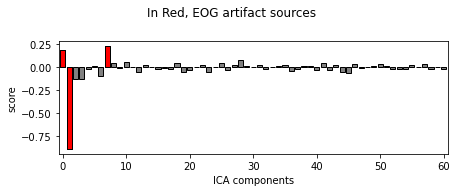

[1, 7, 0]

Using EOG channel: EXG2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency

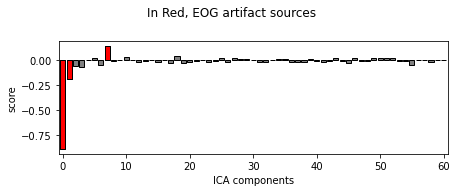

[0, 1, 7]

Using EOG channel: EXG3
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency

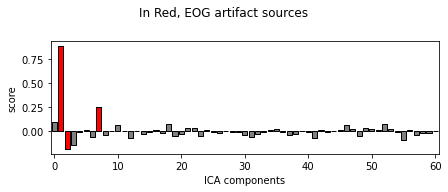

[1, 7, 2]

Using EOG channel: EXG4
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency

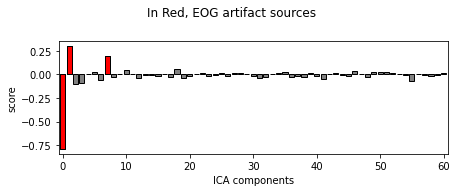

[0, 1, 7]



In [96]:
# auto-detect EOG channels
bad_comps = set()

for eog_channel in RAW_EOG_CHANNELS:
    bad, scores = ica.find_bads_eog(filtered_data, ch_name=eog_channel) 
    ica.plot_scores(scores, exclude=bad, title='In Red, EOG artifact sources')
    bad_comps.update(bad)
    print(bad)
    print("=========================\n")

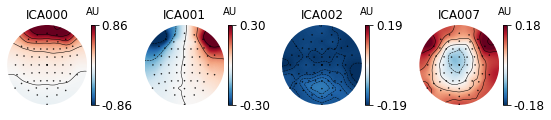

In [97]:
# view ica components to remove
ica.plot_components(picks=list(bad_comps), ch_type='eeg', title='', colorbar=True, show=True);

In [105]:
ica.exclude = list(bad_comps)

# apply the transformation
postica_data = ica.apply(filtered_data, exclude=ica.exclude)
#ica.plot_components(ch_type='eeg', title='', colorbar=True, show=True);
#ica.plot_properties(filtered_data, ch_type='eeg', title='', colorbar=True, show=True);

Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 4 ICA components
    Projecting back using 61 PCA components


In [ ]:
# save ICA result for later
#ica.save('data/P09-ica.fif')